# Getting reduced costs in the ME-model

In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

In [3]:
model = coralme.io.pickle.load_pickle_me_model("./pputidame/MEModel-step3-pputida-Keff.pkl")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03
Read LP format model from file /tmp/tmp2wdsotkz.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp_ij77wyl.lp
Reading time = 0.01 seconds
: 2162 rows, 5896 columns, 23426 nonzeros
Read LP format model from file /tmp/tmphkggf25t.lp
Reading time = 0.01 seconds
: 2166 rows, 5894 columns, 23388 nonzeros


In [5]:
fluxes = pandas.read_csv("./datasets/predictions/KT2440-UPF36-M9-cost.csv",index_col=0)["fluxes"]

### Reduced cost

In [6]:
from coralme.solver.solver import ME_NLP
import cobra
def _solver_solution_to_cobrapy_solution(model, muopt, xopt, yopt, zopt, stat, solver = 'qminos'):
    if solver in ['qminos', 'gurobi']:
        #f = sum([ rxn.objective_coefficient * xopt[idx] for idx, rxn in enumerate(self.reactions) ])
        #x_primal = xopt[ 0:len(self.reactions) ]   # The remainder are the slacks
        x_dict = { rxn.id : xopt[idx] for idx, rxn in enumerate(model.reactions) }
        y_dict = { met.id : yopt[idx] for idx, met in enumerate(model.metabolites) }
        z_dict = { rxn.id : zopt[idx] for idx, rxn in enumerate(model.reactions) }
    elif solver == 'cplex':
        #x_primal =
        x_dict = { rxn.id: xopt[rxn.id].solution_value for idx, rxn in enumerate(self.reactions) }
        y_dict = { met.id: yopt[met.id].dual_value for idx, met in enumerate(self.metabolites) }
        z_dict = { rxn.id: zopt[rxn.id].reduced_cost for idx, rxn in enumerate(self.reactions) }
    else:
        raise ValueError('solver output not compatible.')
    
    #self.me.solution = Solution(f, x_primal, x_dict, y, y_dict, 'qminos', time_elapsed, status)
    return cobra.core.Solution(
        objective_value = muopt,
        status = stat,
        fluxes = x_dict, # x_primal is a numpy.array with only fluxes info
        reduced_costs = z_dict,
        shadow_prices = y_dict,
        )
def get_nlp(model):
    # Call construct LP problem function from model to get precursor objects.
    # lamdify = True -> Creates lambdify functions to calculate bounds as a function of mu
    # per_position = True -> LB and UB bounds as list of lambdify instead of a lambdify to 
    # be able to change individual values
    Sf, Se, lb, ub, b, c, cs, atoms, lambdas, Lr, Lm = model.construct_lp_problem(lambdify=True,per_position=True)

    # Construct NLP object from precursor objects
    me_nlp = ME_NLP(Sf, Se,b, c, lb, ub,  cs, atoms, lambdas)
    return me_nlp
    
def get_reduced_costs(model,me_nlp,rxn_idx,mu_opt):
    # Open biomass dilution bounds
    me_nlp.xl[rxn_idx["biomass_dilution"]] = lambda mu : 0.
    me_nlp.xu[rxn_idx["biomass_dilution"]] = lambda mu : 1000.
    # Set new objective coefficient
    me_nlp.c = [1.0 if r=="biomass_dilution" else 0.0 for r in rxn_idx]
    # Solve at muopt
    xopt, yopt, zopt, stat, _basis = me_nlp.solvelp(muf = mu_opt, basis = None, precision = "quad")
    return _solver_solution_to_cobrapy_solution(model, mu_opt, xopt, yopt, zopt, stat)

In [9]:
proteins = [m for m in model.metabolites if isinstance(m,coralme.core.component.TranslatedGene)]
for p in proteins:
    model.add_boundary(p,lb=0,ub=0,type="sink")

In [12]:
model.reactions.query("SK_protein")[0]

Reaction identifier,SK_protein_PP_0003
Name,sink
Memory address,0x7f9cac13d8d0
Stoichiometry,1.0 protein_PP_0003 --> 1.0 protein_PP_0003 -->
GPR,
Lower bound,0
Upper bound,0
Reaction type,coralme.core.reaction.MEReaction
Flux,ME-model not optimized/feasible
Reduced cost,ME-model not optimized/feasible
Bound violation,ME-model not optimized/feasible


In [13]:
me_nlp = get_nlp(model)
rxn_idx =  {rxn.id : idx for idx, rxn in enumerate(model.reactions)}
mu_opt = fluxes["biomass_dilution"]
costs = get_reduced_costs(model,me_nlp,rxn_idx,mu_opt)

In [26]:
costs.to_frame().to_csv("./datasets/predictions/KT2440-UPF36-M9-cost.csv")

In [59]:
c = costs[costs.index.str.contains("SK_protein")]["reduced_costs"]
c = c[c<0].abs()
c.name = "cost"
c.index = [r.split("SK_protein_")[-1] for r in c.index]

In [61]:
f = fluxes[fluxes.index.str.contains("translation_")]*1e9
f.name = "flux"
f.index = [r.split("translation_")[-1] for r in f.index]

/home/jt/venvs/coralme/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/jt/venvs/coralme/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


(-5.0, 2.0)

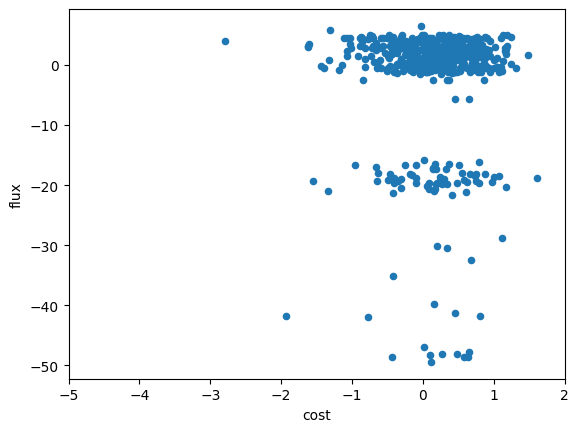

In [70]:
df = pandas.concat([c,f],axis=1)
numpy.log10(df).plot.scatter(x="cost",y="flux")
plt.xlim([-5,2])

In [64]:
df

,cost,flux
PP_0003,8.740568,0.056545
PP_0008,4.980627,1.353065
PP_0026,1.805433,0.031240
PP_0037,0.130628,1251.940432
PP_0041,1.802025,0.000000
...,...,...
PP_5412,NaN,114197.891551
PP_5413,NaN,114197.891551
PP_5414,NaN,114197.891551
PP_5416,NaN,114197.891551


In [69]:
numpy.log10(df).sort_values("cost").dropna()

/home/jt/venvs/coralme/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/jt/venvs/coralme/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


,cost,flux
PP_1664,-27.481708,2.960255
PP_4188,-2.788874,4.065109
PP_4300,-1.935593,-41.808264
PP_4810,-1.614476,3.234735
PP_1771,-1.614476,3.011041
...,...,...
PP_1678,1.250041,0.162413
PP_2638,1.250485,-inf
PP_4220,1.310892,-0.440924
PP_1333,1.480496,1.634410
